In [1]:
import jax.numpy as jnp
import jax
from functools import partial
from jax import random
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
rng = random.PRNGKey(0)

class Net(nn.Module):
    n_hidden: int
    n_output: int

    @nn.compact
    def __call__(self, x):
        x = nn.relu( nn.Dense(self.n_hidden)(x) )
        x = nn.relu( nn.Dense(self.n_hidden)(x) )
        x = nn.Dense(self.n_output)(x)
        return x
    
    @staticmethod
    @jax.jit
    def update(model_state: TrainState, inputs: jnp.ndarray, targets: jnp.ndarray):

        def loss_fn(params):
            predictions = model_state.apply_fn(params, inputs)
            return jnp.mean((targets-predictions)**2)

        loss, grads = jax.value_and_grad(loss_fn)(model_state.params)
        model_state = model_state.apply_gradients(grads=grads)
        return model_state, loss
    
def create_state(rng, model, in_shape, learning_rate):
    params = model.init(rng, jnp.zeros(in_shape))
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=jax.jit(model.apply), params=params, tx=tx)


In [3]:
rng, key = random.split(rng)
in_shape = (1,1)
model = Net(n_hidden=64, n_output=1)
model_state = create_state(key, model, in_shape, 0.003)

In [4]:
example_model = Net(n_hidden=4, n_output=1)
example_model_state = create_state(key, model, in_shape, 0.003)
example_model_state.params

{'params': {'Dense_0': {'kernel': Array([[-1.2217504 ,  0.20437928, -1.3664776 , -0.48741812,  0.5005433 ,
            1.2300909 ,  0.12462698, -0.63897663, -0.4784836 ,  2.1295152 ,
            1.439418  ,  0.5209977 ,  1.6105922 , -0.16393115,  0.2602641 ,
           -0.18480253,  0.4661113 , -0.39332718, -0.36880225, -1.0379002 ,
           -0.5072562 ,  0.2150917 ,  0.46362036,  0.7043038 ,  0.625791  ,
           -0.6948339 ,  0.9666126 , -0.9463511 ,  0.30791417,  0.43891054,
            0.31421292,  0.09934568, -0.8155425 , -0.05118013,  0.16150634,
            0.03549281, -1.9374045 , -0.3793841 ,  1.6432722 ,  0.8338093 ,
            0.5035813 , -0.7912319 ,  1.6720394 , -0.21112017,  0.69369054,
           -0.68411237,  0.8555481 ,  0.20750436,  0.74854505,  0.7787621 ,
            0.32906726, -0.5392347 , -0.8471882 ,  1.0353243 , -0.54826057,
           -0.9383725 , -0.31728804, -0.60597354,  0.04480749,  0.86545116,
           -0.919244  ,  0.44396418, -0.7567101 ,  1.1096

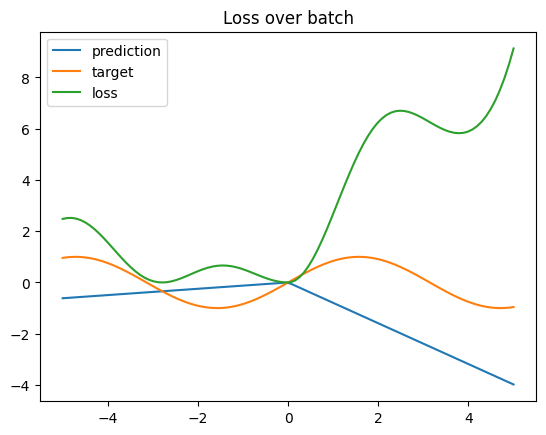

In [5]:
xrange_inputs = jnp.linspace(-5,5,100).reshape((100,1))
targets = jnp.sin(xrange_inputs)
loss_example = lambda data, label: (data-label)**2
prediction = model_state.apply_fn(model_state.params, xrange_inputs)
plt.plot(xrange_inputs, prediction, label='prediction')
plt.plot(xrange_inputs, targets, label='target')
plt.plot(xrange_inputs, (prediction-targets)**2, label='loss')
plt.title("Loss over batch")
plt.legend()
plt.show()

In [6]:
# model_state = create_state(key, model, in_shape, 0.003)
losses = []

for i in range(100):
    model_state, loss = model.update(model_state=model_state, inputs=xrange_inputs, targets=targets)
    losses.append(loss)

In [7]:
# xrange_inputs = jnp.linspace(-5,5,100).reshape((100,1))
# targets = jnp.sin(xrange_inputs)
predictions = model_state.apply_fn(model_state.params, xrange_inputs)

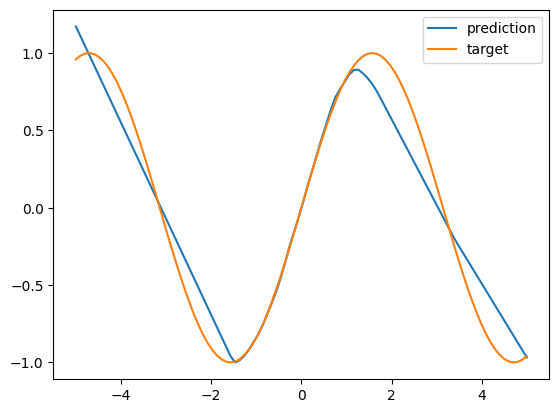

In [8]:
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()
plt.show()

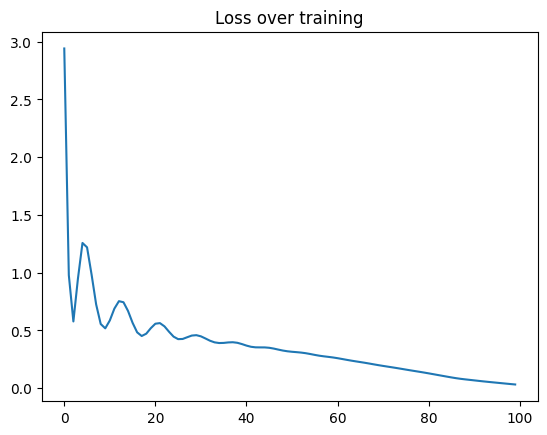

In [9]:
plt.plot(jnp.arange(len(losses)), losses)
plt.title("Loss over training")
plt.show()